# Clustering en Compras en Centros Comerciales 

El clustering (segmentación) es una de las tareas más relevantes dentro en el mundo del Machine Learning. Los algoritmos de agrupación son comunes en casi todas las industrias. Desde astronomía para segmentar entre tipos de cuerpos y galaxias, hasta el marketing para segmentar clientes. 

En este Notebook realizaremos una introducción algoritmos de Clustering en Python utilizando un dataset académico de compras en un Centro Comercial.

In [1]:
# for basic mathematics operation 
import numpy as np
import pandas as pd
from pandas import plotting

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')


**Reading the Dataset**

In [2]:
# importing the dataset
url = "https://raw.githubusercontent.com/patofw/imf_master/master/Google_Colab/datasets_42674_74935_Mall_Customers.csv"
data = pd.read_csv(url)

data.head()

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

In [3]:
#  describimos las variables 
data.describe()

CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000

In [4]:
# revisamos el formato de cada columna y si tienen datos nulos

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


## EDA

Exploremos las variables incialmente. Se puede ver que es un dataset sencillo, pero como primera intución podemos ver si hay diferencias entre los hombres y mujeres en sus patrones de compra. Una buena alternativa es utilizando las [Curvas de Andrew](https://en.wikipedia.org/wiki/Andrews_plot) que mediante unas transformaciones multidimensionales nos permiten ver si los datos son discrimintes entre variables categóricas. O en otras palabras, si los patrones son distintos entre grupos. En este caso lo ejecutamos con la API de Plotting incorporada de Pandas

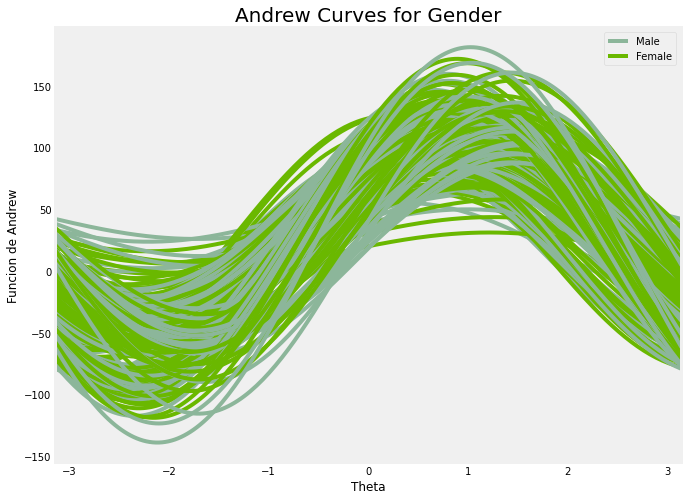

In [5]:
plt.rcParams['figure.figsize'] = (10, 8)

# Lanzamos el análisis por género, quitando la columna de ID
plotting.andrews_curves(data.drop("CustomerID", axis=1), "Gender")
plt.title('Andrew Curves for Gender', fontsize = 20)
plt.xlabel("Theta")
plt.ylabel('Funcion de Andrew')
plt.show(); 

No parecen haber notables diferencias entre los grupos, por ello están muy entrelazados los cables. Cargemos momentáneamente otro ejemplo para ver como se representaría una curva de Andrew entre segmentos diversos. 

In [6]:
iris_data = sns.load_dataset('iris') # cargamos dataset de Iris.
iris_data.head()


sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

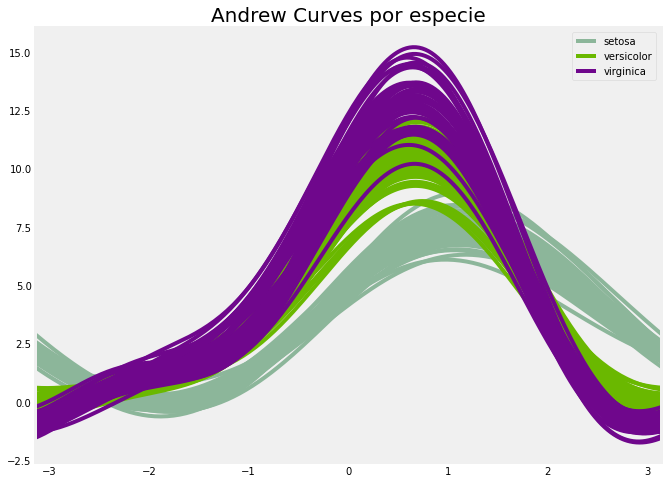

In [7]:
plotting.andrews_curves(iris_data, "species")
plt.title('Andrew Curves por especie', fontsize = 20)
plt.show();

Seguimos explorando la compra en los malls

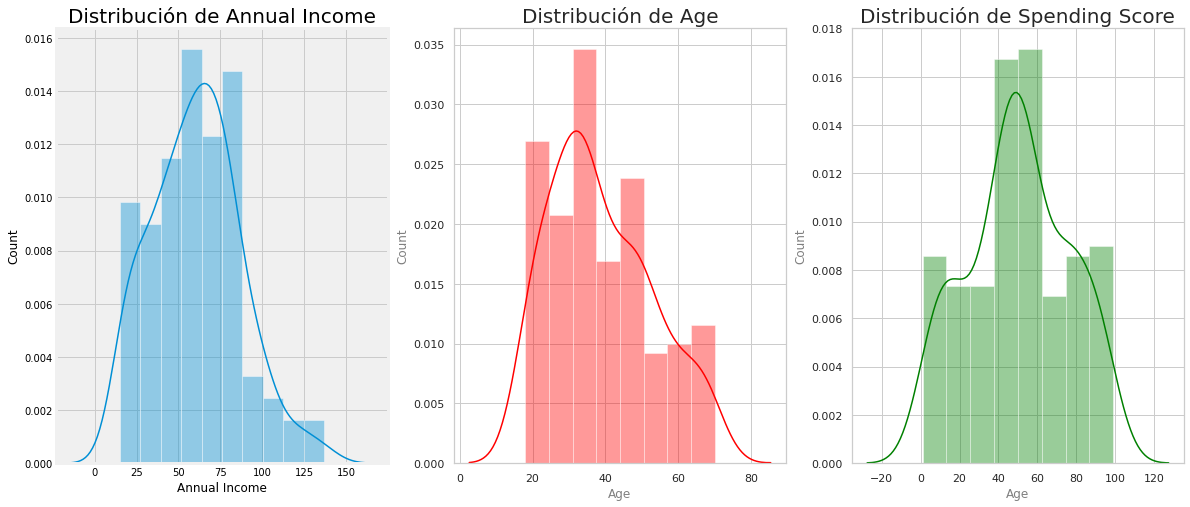

In [8]:
plt.rcParams['figure.figsize'] = (18, 8)
# Distribución de las variables 
## Income
plt.subplot(1, 3, 1) # 1 fila, 3 columnas, pos 1
sns.set(style = 'whitegrid')
sns.distplot(data['Annual Income (k$)']) # pinta la distribución 
plt.title('Distribución de Annual Income', fontsize = 20)
plt.xlabel('Annual Income')
plt.ylabel('Count')

## Edad 
plt.subplot(1, 3, 2) # 1 fila, 3 columnas, pos 2
sns.set(style = 'whitegrid')
sns.distplot(data['Age'], color = 'red')
plt.title('Distribución de Age', fontsize = 20)
plt.xlabel('Age', color = "grey")
plt.ylabel('Count', color = "grey")

## Valor como consumidor 

plt.subplot(1, 3, 3) # 1 fila, 3 columnas, pos 3
sns.set(style = 'whitegrid')
sns.distplot(data['Spending Score (1-100)'], color = 'green')
plt.title('Distribución de Spending Score', fontsize = 20)
plt.xlabel('Age', color = "grey")
plt.ylabel('Count', color = "grey")


plt.show();


Es interesante ver que las variables tienen distribuciones relativamete normales, no tenemos aparentemente Outliers importantes. 
Exploremos ahora la relación entre las variables numéricas.

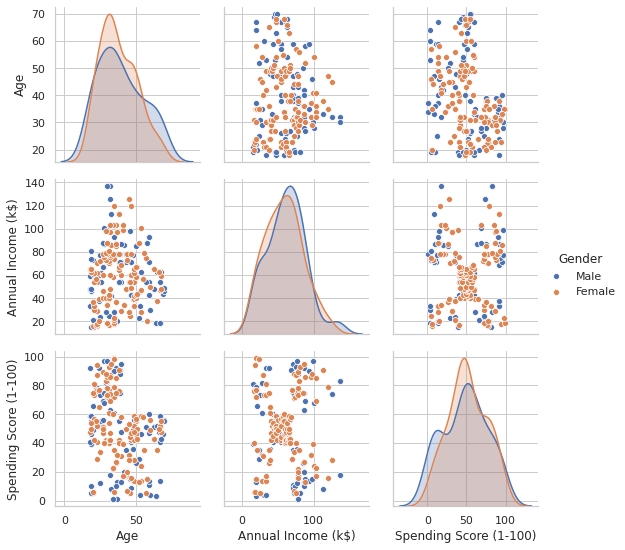

In [9]:
# Si lo queremos hacer de forma automática.
sns.pairplot(data.drop('CustomerID',axis=1), hue='Gender')
plt.show();

Interesante la relación entre Spending Score e Income. **Qué nos dice este gráfico?**

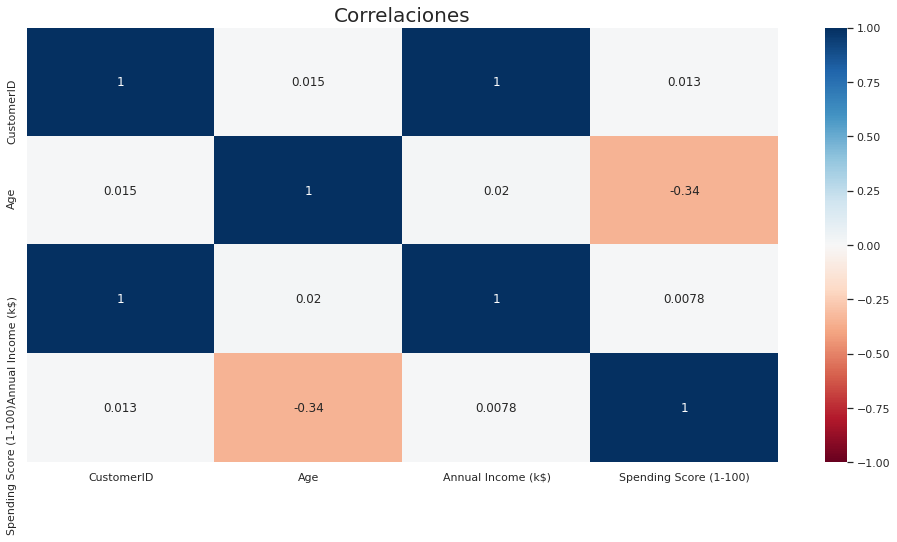

In [10]:
plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(data.corr('spearman'), cmap = 'RdBu',  # correlación de spearman
            annot = True, vmax=1,vmin=-1)
plt.title('Correlaciones', fontsize = 20)
plt.show()

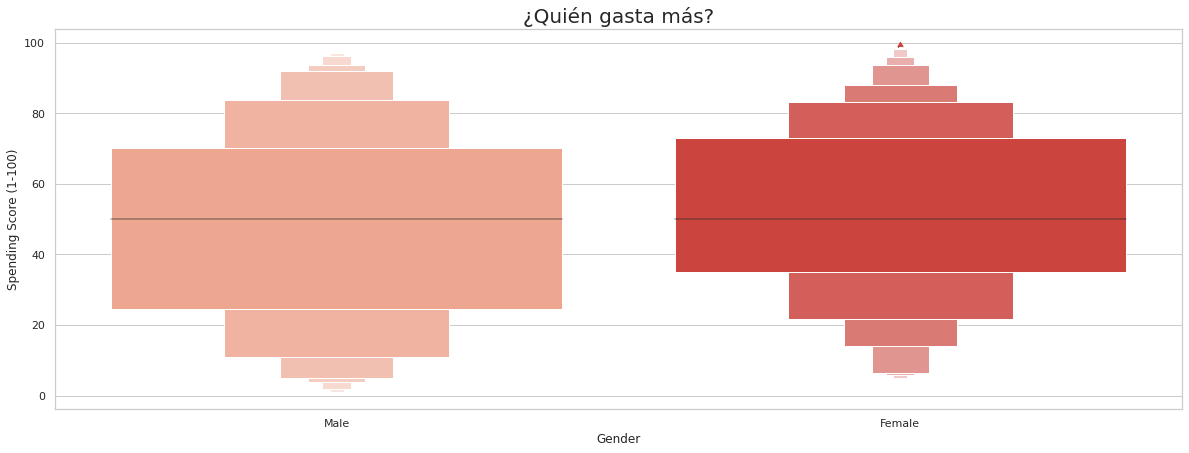

In [11]:
#  Quien gasta más mujeres u hombres

plt.rcParams['figure.figsize'] = (18, 7)
sns.boxenplot(data['Gender'], data['Spending Score (1-100)'], 
              palette = 'Reds')
plt.title('¿Quién gasta más?', fontsize = 20)
plt.show()

## Clustering 

En este tutorial veremos dos de los más comunes: Kmeans y Clustering Jerárquico. Recuerda que para estos algoritmos es necesario pasarle datos numéricos idealmente continuos

In [12]:
data.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

In [13]:
# TOmamos solo las columnas numéricas que nos interesan
X = data[['Annual Income (k$)',
       'Spending Score (1-100)']].values

# let's check the shape of x
print(X.shape)

(200, 2)


## Kmeans Algorithm

**Número óptimo de Clusters con la curva de brazo**

Es recomendable utilizar métodos matemáticos para elegir la cantidad de clusters que queremos obtener. Aunque esto dependera realmente del caso de uso

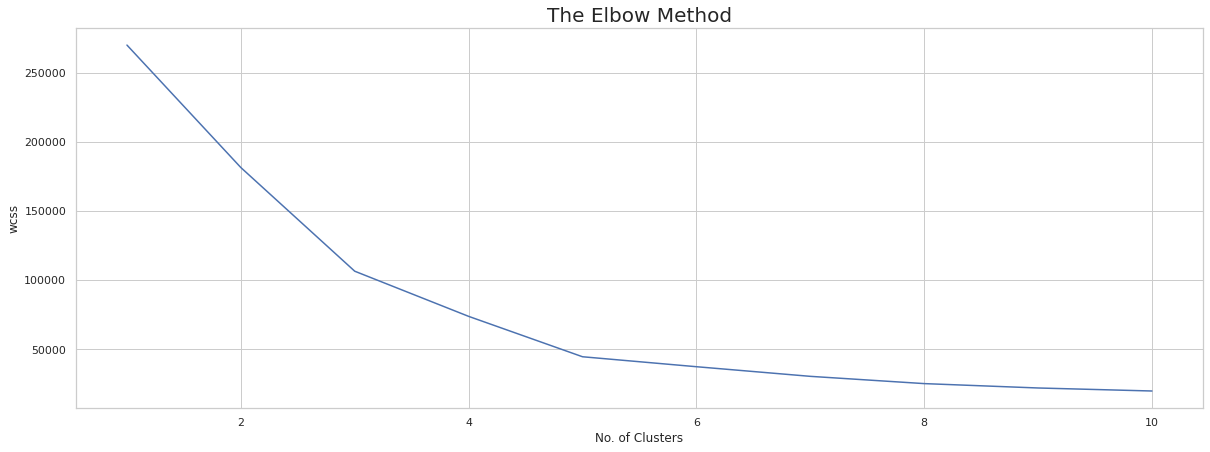

In [14]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(X)
    wcss.append(km.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

En este caso, buscamos los codos del brazo. Una alternativa parece ser 5 clusters

**Visualizando los Clusters**

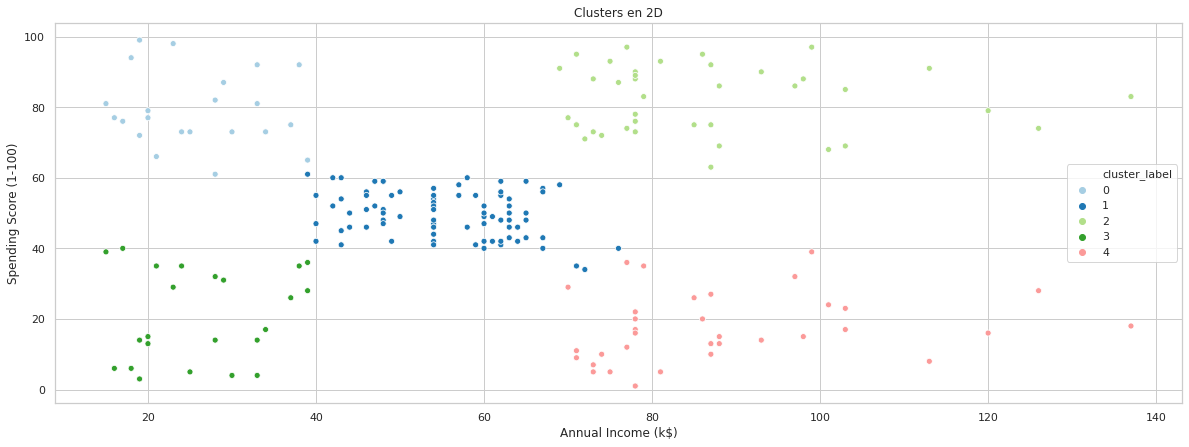

In [15]:
n_clusters = 5 # número de clusters. Puedes modificarlo y ver que sucede

km = KMeans(n_clusters = n_clusters, init = 'k-means++',
            max_iter = 100, n_init = 10, random_state = 42) # algunos parametros
y_means = km.fit_predict(X) # realizamos el ajuste de aprendizaje

# Lo ploteamos. Primero en crudo, luego lo decoramos. 

clusters_df = pd.DataFrame(X, 
             columns = ['Annual Income (k$)',
                        'Spending Score (1-100)'])
clusters_df['cluster_label'] = y_means

sns.scatterplot(x ='Annual Income (k$)',
                y = 'Spending Score (1-100)', hue = 'cluster_label',
                data = clusters_df,
                palette = 'Paired')
plt.title("Clusters en 2D")
plt.show();

**Podemos darles nombres a los clusters y dibujar sus centroides**

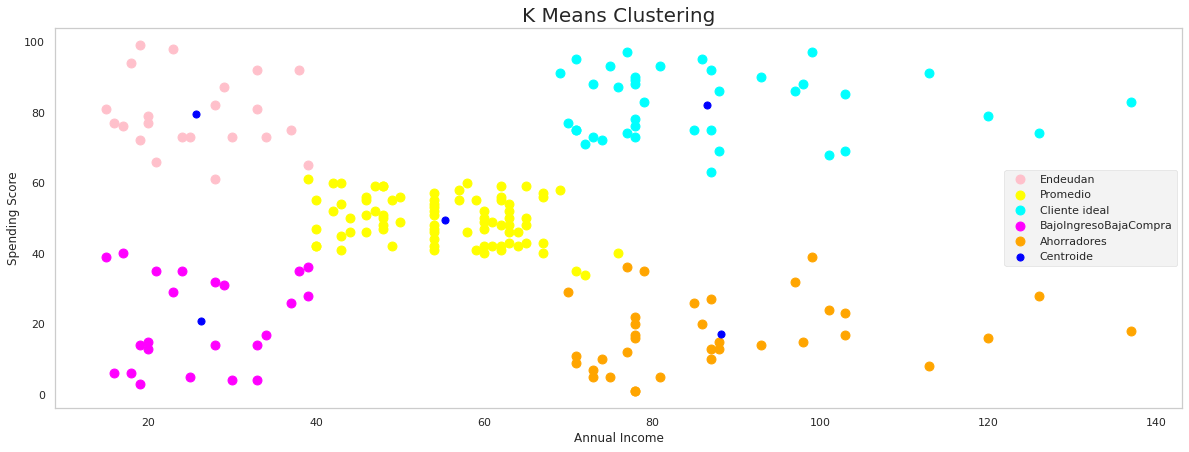

In [16]:

plt.scatter(X[y_means == 0, 0], X[y_means == 0, 1], s = 80, c = 'pink', label = 'Endeudan')
plt.scatter(X[y_means == 1, 0], X[y_means == 1, 1], s = 80, c = 'yellow', label = 'Promedio')
plt.scatter(X[y_means == 2, 0], X[y_means == 2, 1], s = 80, c = 'cyan', label = 'Cliente ideal')
plt.scatter(X[y_means == 3, 0], X[y_means == 3, 1], s = 80, c = 'magenta', label = 'BajoIngresoBajaCompra')
plt.scatter(X[y_means == 4, 0], X[y_means == 4, 1], s = 80, c = 'orange', label = 'Ahorradores')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'Centroide')

plt.style.use('fivethirtyeight')
plt.title('K Means Clustering', fontsize = 20)
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.grid()
plt.show()

## Clustering Jerárquico

Este es uno de los tipos de clusters más utilizados en el mundo. Pues dividen a los grupos de forma jerárquica (como un árbol), lo que resulta es fácilmente explicable de forma visual. 

**Dendogramas**



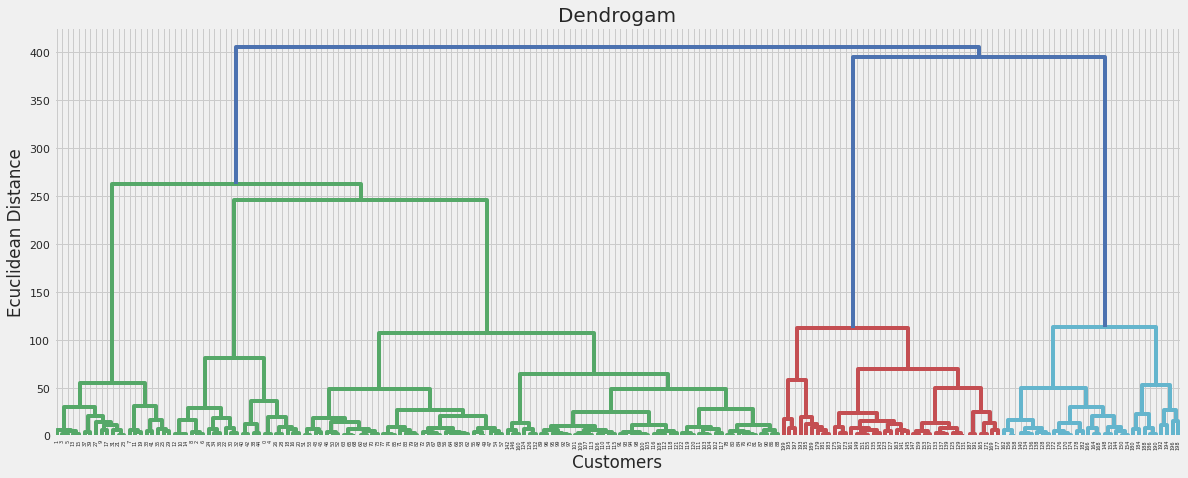

In [17]:
import scipy.cluster.hierarchy as sch # Importamos el tipo de cluster de Scipy
# Calculamos el linkage (enlace) entre los puntos 
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward')) # métdo de ward es el más común. 
plt.title('Dendrogam', fontsize = 20)
plt.xlabel('Customers')
plt.ylabel('Ecuclidean Distance')
plt.show();

## Visualizando los Clusters


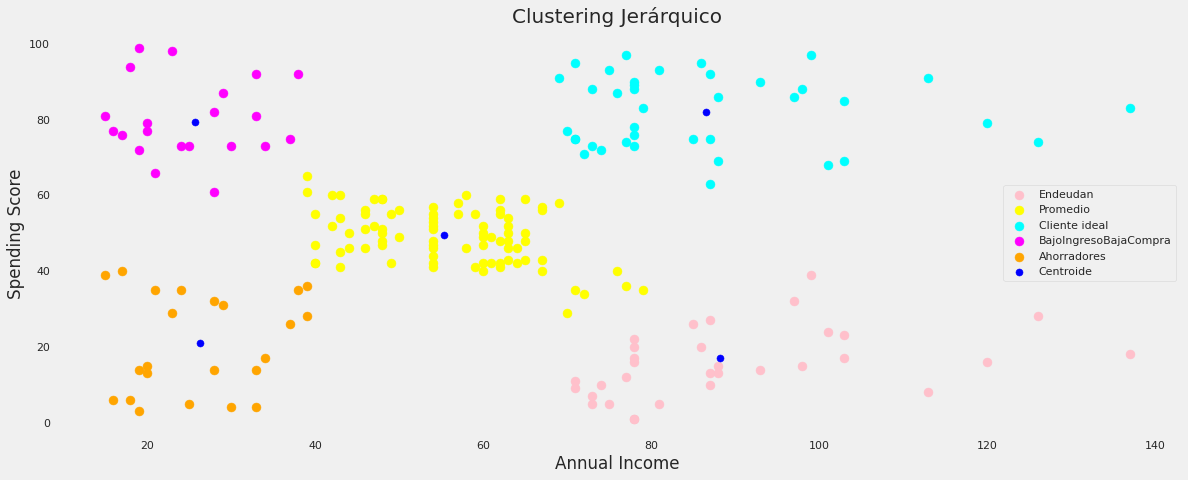

In [18]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(n_clusters = n_clusters, affinity = 'euclidean',
                             linkage = 'ward')
y_hc = hc.fit_predict(X) # hacemos el fit con el tipo de algoritmo anterior
# Plot con labels 
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 80, c = 'pink', label = 'Endeudan')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 80, c = 'yellow', label = 'Promedio')
plt.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s = 80, c = 'cyan', label = 'Cliente ideal')
plt.scatter(X[y_hc == 3, 0], X[y_hc == 3, 1], s = 80, c = 'magenta', label = 'BajoIngresoBajaCompra')
plt.scatter(X[y_hc == 4, 0], X[y_hc == 4, 1], s = 80, c = 'orange', label = 'Ahorradores')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'Centroide') # Centroides

plt.style.use('fivethirtyeight')
plt.title('Clustering Jerárquico', fontsize = 20)
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.grid()
plt.show();